# RnaSeqExample


This is an example of a bioinformatics pipeline that uses Reflow, Spark, and some R packages.




In [1]:
// Set up the S3 file system for Hadoop
spark.sparkContext.hadoopConfiguration.set("fs.s3a.impl", 
    "org.apache.hadoop.fs.s3a.S3AFileSystem"
)

In [2]:
object Ref {
  // Reference genomes
  val genomes = Map(
    'C_elegans -> "ftp://ftp.ensembl.org/pub/release-99/fasta/caenorhabditis_elegans/cdna/Caenorhabditis_elegans.WBcel235.cdna.all.fa.gz"
  )
}

In [3]:
// Study: https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP253718
val runProperties = Seq(
  ("SRR11392700", "wild-type"),
  ("SRR11392701", "wild-type"),
  ("SRR11392702", "wild-type"),
  ("SRR11392703", "oef-1(vr25)"),
  ("SRR11392704", "oef-1(vr25)"),
  ("SRR11392705", "oef-1(vr25)")
).toDF("sraAcc", "genotype")

In [4]:
// Where to store the feature counts on s3
val outputPrefix = "s3a://exploratory-pipeline-example/count/"

In [5]:
// Count the features by using a Reflow pipeline, in batch mode.
import io.hchauvin.bio.RnaSeq
import io.hchauvin.reflow.Reflow
import java.nio.file.Paths

val runs = runProperties
    .map(r => RnaSeq.Run(r.getAs[String]("sraAcc"), Ref.genomes('C_elegans)))
    .collect

val rf = new Reflow(batchParentPath = Paths.get("batch"))
val featureCounts = RnaSeq.batch(rf, "count", outputPrefix, runs)

stdout: 
stderr: reflow: batch program /Users/chauvin/code/exploratory-pipeline-example/bioinformatics/src/main/resources/io/hchauvin/bio/workflows/rna_seq.rf runsfile /Users/chauvin/Downloads/polynote/batch/count/batch_csv/part-00000-8205ac0b-f79f-4d3a-8c4a-ff21a9683503-c000.csvreflow: run SRR11392704: done: val<>reflow: run SRR11392705: done: val<>reflow: run SRR11392701: done: val<>reflow: run SRR11392703: done: val<>reflow: run SRR11392702: done: val<>reflow: run SRR11392700: done: val<>


In [6]:
// Normalize the feature counts so that the quantiles are the same
// across the samples.
import io.hchauvin.bio.Stringtie
import io.hchauvin.r

val normalizedFeatureCounts = Stringtie.toExpressionMatrix(featureCounts)
    .normalizeQuantiles()

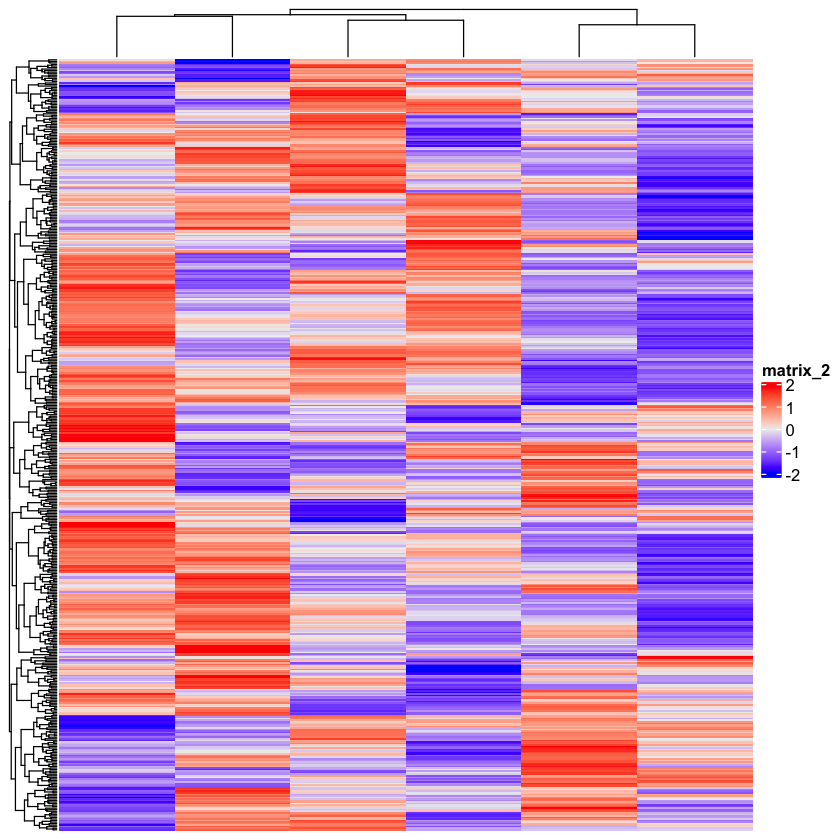

In [7]:
// Create a heatmap for the leading genes, in terms of
// relative change in the genotypes.
import io.hchauvin.r

r.assign("mat", normalizedFeatureCounts.rexp)

r.$("""mat %>%
    matrix(., ncol=6)""")

io.hchauvin.r.plot("""
library(magrittr)

# Workaround because somehow JRI transforms a matrix into a vector.
mat %<>%
    matrix(., ncol=6)

fit <- mat %>%
    limma::lmFit(
        # Design matrix
        cbind(
            Quiescence=1,
            OefVsWT=c(rep(0, 3), rep(1, 3))
        )
    )

bayes <- fit %>%
    limma::eBayes(trend=TRUE, robust=FALSE)

z_score <- function (x) {
    (x - mean(x, na.rm=TRUE)) / sd(x, na.rm=TRUE)
}

library(magrittr)
mat %>%
    .[order(bayes$lods,decreasing=TRUE)[1:500],] %>%
    apply(1, z_score) %>%
    t() %>%
    ComplexHeatmap::Heatmap(
        show_row_names = FALSE
    )
""")